In [26]:
import torch
import torchvision.models as models
import onnx
import onnxruntime as ort
import numpy as np
import time
from PIL import Image

### Как преобразовать torch модель в ONNX
Можно преобразовывать модели и из других библиотек Sklearn, TensorFlow и тд, в этом и прелесть ONNX

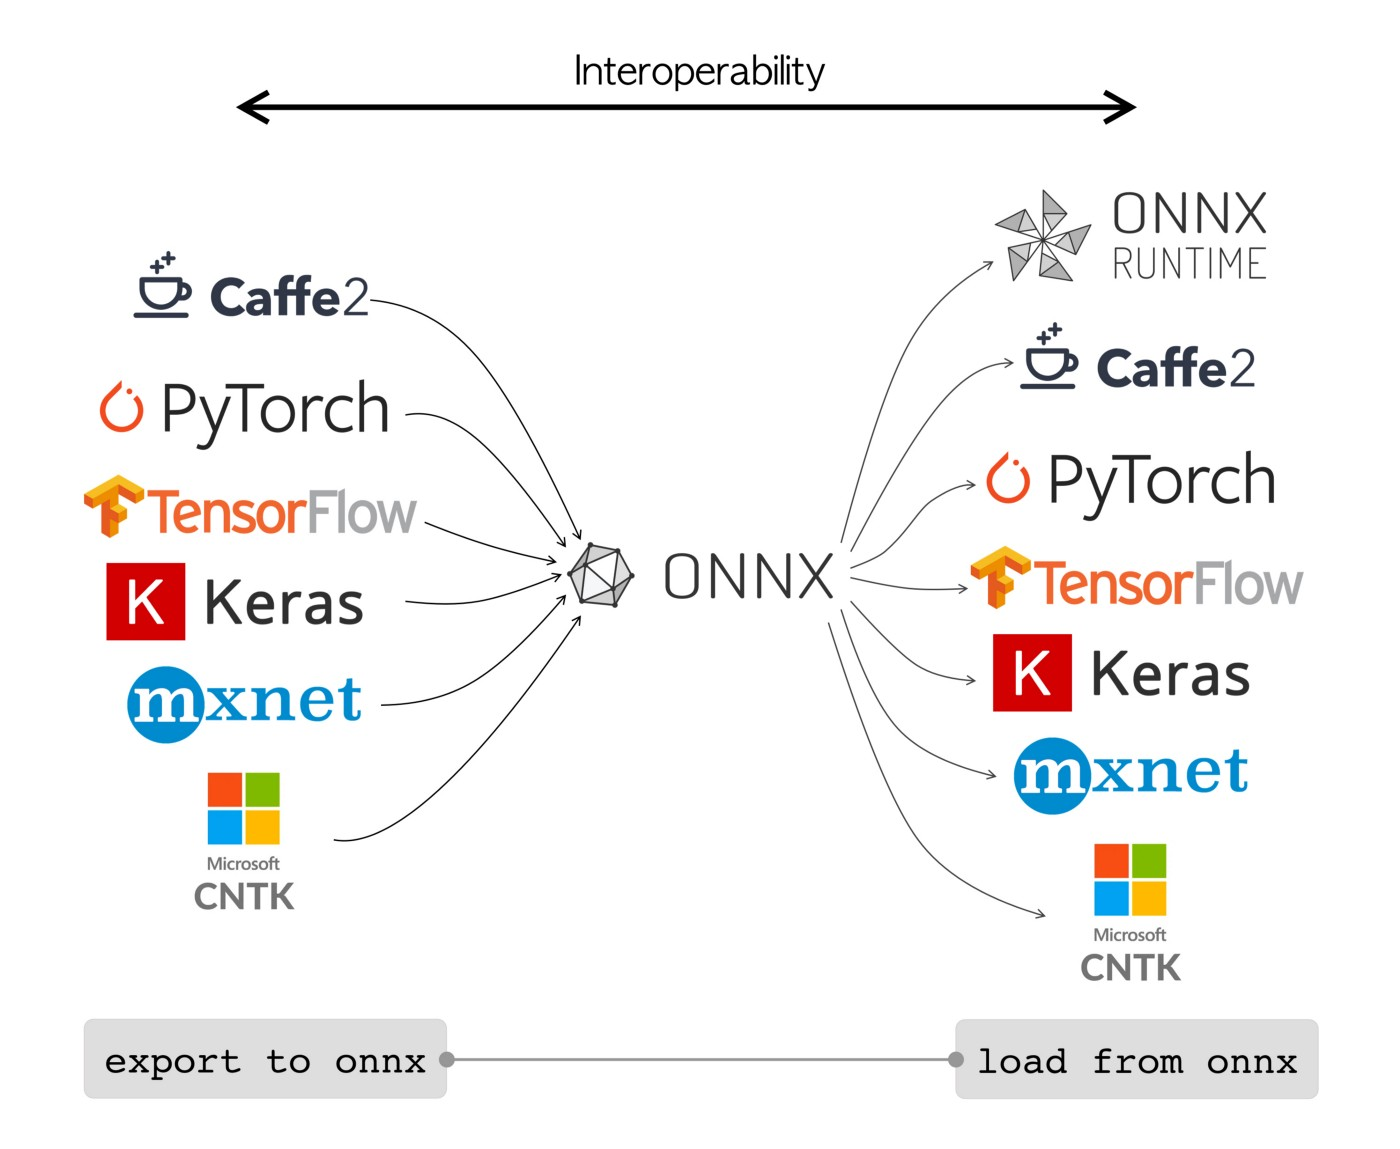

In [3]:
# Загружаем предобученную модель ResNet
model = models.resnet18(pretrained=True)
model.eval()  # Переключаем модель в режим оценки

# Создаем случайный тензор для входных данных
dummy_input = torch.randn(1, 3, 224, 224)  # Формат: [batch_size, channels, height, width]
dummy_output = model(dummy_input)
print(dummy_output.shape)

torch.Size([1, 1000])


Теперь, когда модель готова, пришло время экспортировать ее. Для этого используем метод torch.onnx.export()

In [5]:
checkpoint_path = "../checkpoints/resnet18.onnx"

torch.onnx.export(model, 
                  dummy_input, 
                  checkpoint_path, 
                  export_params=True, 
                  opset_version=11,  # Версия ONNX
                  do_constant_folding=True,  # Оптимизация
                  input_names=['input'],  # Названия входных слоев
                  output_names=['output'],  # Названия выходных слоев
                  dynamic_axes={'input': {0: 'batch_size'}, 'output': {0: 'batch_size'}})

print("Модель успешно экспортирована в формат ONNX!")

Модель успешно экспортирована в формат ONNX!


### Как запустить инференс модели ONNX

In [6]:
ort_session = ort.InferenceSession(checkpoint_path)

In [11]:
inputs = ort_session.get_inputs()
for item in inputs:
    print(f"Input name: {item.name}, shape: {item.shape}, type: {item.type}")

outputs = ort_session.get_outputs()
for item in outputs:
    print(f"Output name: {item.name}, shape: {item.shape}, type: {item.type}")

Input name: input, shape: ['batch_size', 3, 224, 224], type: tensor(float)
Output name: output, shape: ['batch_size', 1000], type: tensor(float)


In [17]:
# Выполняем предсказание
outputs = ort_session.run(None, {'input': np.array(dummy_input)})

# Вывод предсказания
predicted_class = np.argmax(outputs[0])  # Получаем класс с максимальной вероятностью
print(f"Предсказанный класс: {predicted_class}")

Предсказанный класс: 107


In [23]:
onnx_model = onnx.load(checkpoint_path)

# Вывод информации о модели
print("Model IR version: ", onnx.version.version)
print("Model opset version: ", onnx_model.opset_import[0].version)

Model IR version:  1.17.0
Model opset version:  11


In [25]:
# Вывод графа модели
print("Model graph:")
# print(onnx.helper.printable_graph(onnx_model.graph))

Model graph:


Теперь протестируем, как быстро работает наша модель на нескольких изображениях. Создадим цикл для тестирования:

In [31]:
total_time = 0
n = 1000

for _ in range(n):
    
    start_time = time.time()
    outputs = ort_session.run(None, {'input': np.array(dummy_input)})
    end_time = time.time()
    
    total_time += end_time - start_time

print(f"Среднее время предсказания: {total_time / n:.4f} секунд")

Среднее время предсказания: 0.0164 секунд
